In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f_oneway, f

In [2]:
# Load dataset
file_path = "Bodyfat.txt"
fat = pd.read_csv(file_path, sep=" ", decimal=".")

# Overview of dataset structure
print(fat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   %Fat     252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdom    252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  F-arm    252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB
None


In [3]:
# Model with 3 predictors
X1 = fat[["Weight", "Neck", "Abdom"]]
y = fat["%Fat"]

model1 = LinearRegression()
model1.fit(X1, y)

LinearRegression()

In [4]:
# Model summary
y_pred1 = model1.predict(X1)
print("Model 1 Coefficients:", model1.coef_)
print("Model 1 Intercept:", model1.intercept_)
print("Model 1 R^2 Score:", r2_score(y, y_pred1))
print("Model 1 MSE:", mean_squared_error(y, y_pred1))

Model 1 Coefficients: [-0.12054377 -0.43576437  0.99712578]
Model 1 Intercept: -35.01532260115448
Model 1 R^2 Score: 0.7237431617861396
Model 1 MSE: 19.271095843423716


In [5]:
# Prediction for a new individual
new_data1 = pd.DataFrame([[157, 37, 88]], columns=["Weight", "Neck", "Abdom"])
predicted_fat1 = model1.predict(new_data1)
print("Predicted Body Fat Percentage (Model 1):", predicted_fat1[0])

Predicted Body Fat Percentage (Model 1): 17.683092394463294


In [6]:
# Model with more predictors
X2 = fat[["Weight", "Neck", "Abdom", "Wrist", "F-arm"]]

model2 = LinearRegression()
model2.fit(X2, y)

LinearRegression()

In [7]:
y_pred2 = model2.predict(X2)
print("Model 2 Coefficients:", model2.coef_)
print("Model 2 Intercept:", model2.intercept_)
print("Model 2 R^2 Score:", r2_score(y, y_pred2))
print("Model 2 MSE:", mean_squared_error(y, y_pred2))

Model 2 Coefficients: [-0.12279995 -0.36568417  1.00784461 -1.2462846   0.52703346]
Model 2 Intercept: -30.653577479057475
Model 2 R^2 Score: 0.7379161469620583
Model 2 MSE: 18.282418214741412


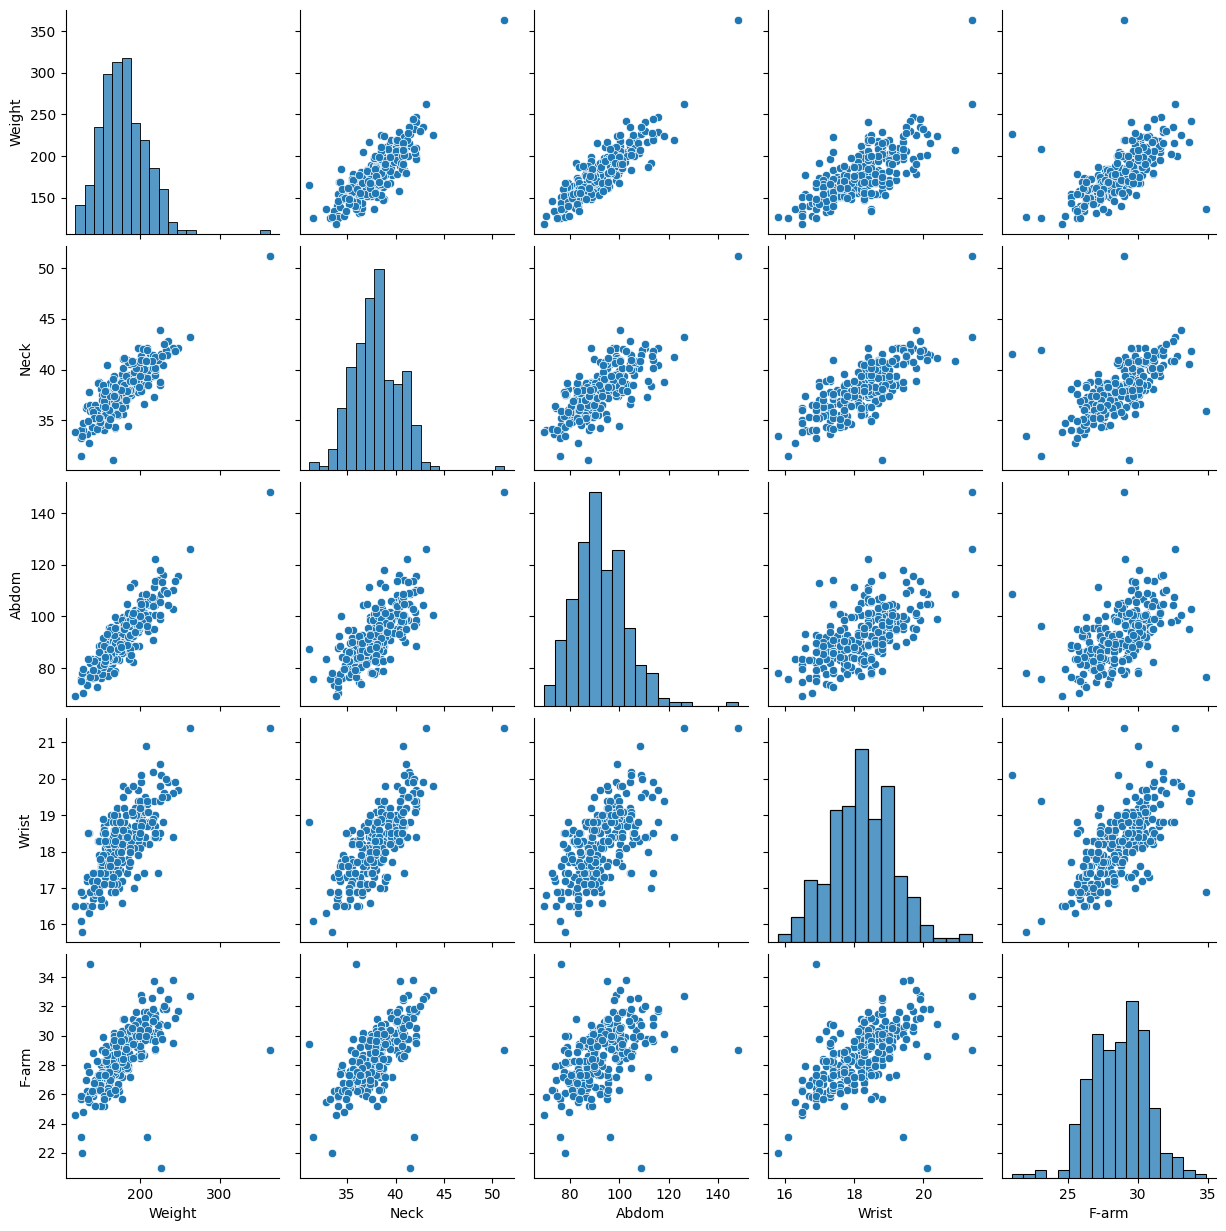

In [8]:
# Visualizing predictor relationships
predictors = ["Weight", "Neck", "Abdom", "Wrist", "F-arm"]
sns.pairplot(fat[predictors])
plt.show()

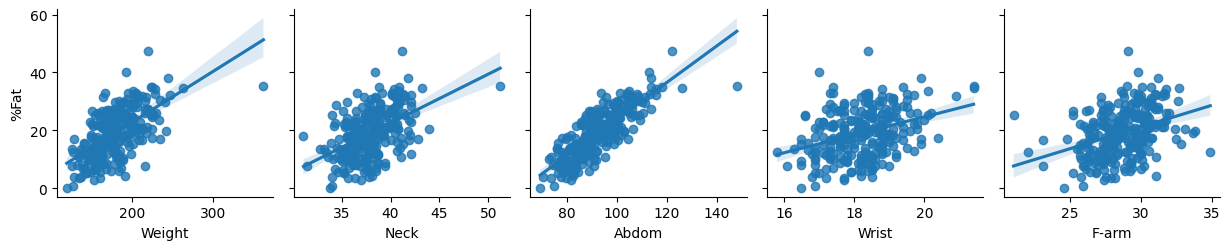

In [9]:
dependent_variable = "%Fat" 

# Create a pairplot showing relationships between predictors and the dependent variable
sns.pairplot(fat, x_vars=predictors, y_vars=dependent_variable, kind="reg")

plt.show()

In [10]:
# Model Comparison (F-test for improvement in larger model)
ssr1 = np.sum((y - y_pred1) ** 2)
ssr2 = np.sum((y - y_pred2) ** 2)

f_stat, p_value = f_oneway(y_pred1, y_pred2)
print("F-statistic:", f_stat)
print("P-value:", p_value)

F-statistic: 2.7010359580030133e-28
P-value: 1.0


In [11]:
"""
f_oneway is designed for ANOVA tests comparing means of multiple independent groups, 
but here, you're comparing residual sums of squares (SSR) from two regression models. 
Instead of f_oneway, we should compute the F-statistic manually for model comparison in regression
"""

"\nf_oneway is designed for ANOVA tests comparing means of multiple independent groups, \nbut here, you're comparing residual sums of squares (SSR) from two regression models. \nInstead of f_oneway, we should compute the F-statistic manually for model comparison in regression\n"

In [12]:
# Model Comparison (F-test for improvement in larger model)
df1 = X2.shape[1] - X1.shape[1]  # Difference in number of predictors
df2 = len(y) - X2.shape[1]  # Residual degrees of freedom for larger model

f_stat = ((ssr1 - ssr2) / df1) / (ssr2 / df2)
p_value = 1 - f.cdf(f_stat, df1, df2)  # Cumulative distribution function for F-test

print("F-statistic:", f_stat)
print("P-value:", p_value)

F-statistic: 6.678639866350518
P-value: 0.001496968472337712
